In [7]:
from aqua import Reader,catalogue, inspect_catalogue
import datetime
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import diag_functions as fn
import warnings

warnings.filterwarnings("ignore", message="Slicing is producing a large chunk.")

In [8]:
reader = Reader(model='FESOM', exp='tco2559-ng5-cycle3', source="lra-r100-monthly")
data = reader.retrieve()

data=data.rename({"nz1":"lev"})
data=data.rename({"ocpt":"thetao"})
data=data[["thetao","so"]]

yearly_data=data.resample(time="Y").mean()
yearly_data

<xarray.Dataset>
Dimensions:  (time: 5, lev: 69, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lev      (lev) float64 2.5 7.5 12.5 17.5 ... 5.525e+03 5.825e+03 6.175e+03
  * time     (time) datetime64[ns] 2020-12-31 2021-12-31 ... 2024-12-31
Data variables:
    thetao   (time, lev, lat, lon) float64 dask.array<chunksize=(1, 69, 180, 360), meta=np.ndarray>
    so       (time, lev, lat, lon) float64 dask.array<chunksize=(1, 69, 180, 360), meta=np.ndarray>

In [9]:
labrador_sea_mean=fn.wgt_area_mean(yearly_data,50, 65, 300, 325)
converted_labrador_sea_mean= convert_variables(labrador_sea_mean)

In [10]:
converted_labrador_sea_mean

<xarray.Dataset>
Dimensions:  (lev: 69, time: 5)
Coordinates:
  * lev      (lev) float64 2.5 7.5 12.5 17.5 ... 5.525e+03 5.825e+03 6.175e+03
  * time     (time) datetime64[ns] 2020-12-31 2021-12-31 ... 2024-12-31
Data variables:
    so       (time, lev) float64 dask.array<chunksize=(1, 69), meta=np.ndarray>
    thetao   (time, lev) float64 dask.array<chunksize=(1, 69), meta=np.ndarray>
    rho      (time, lev) float64 dask.array<chunksize=(1, 69), meta=np.ndarray>

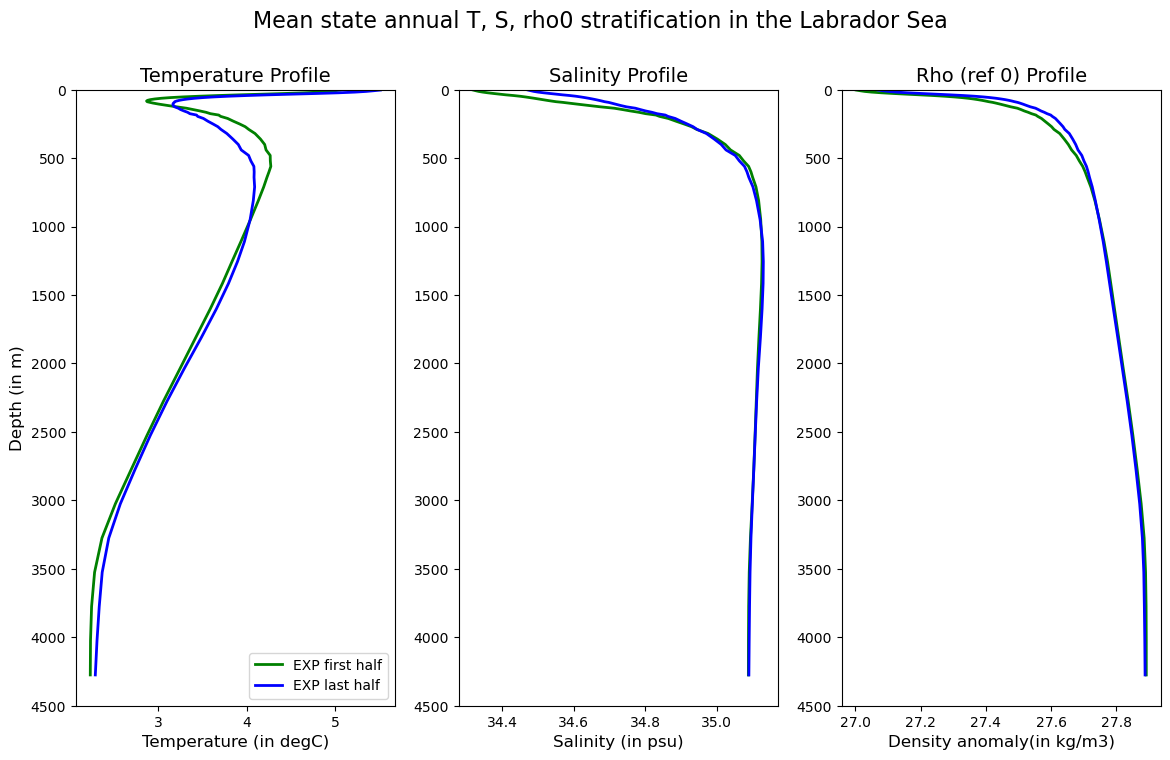

In [11]:
fn.plot_temporal_split(converted_labrador_sea_mean)